# Übungsaufgabe Objektorierntierung

Laden der Funktionsdefinitionen von dem Pendel

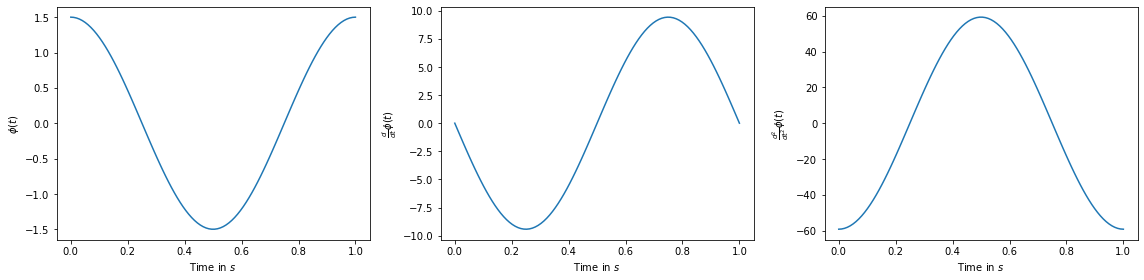

In [15]:
%run ../../../Tag02/01_sympy/Skripte/sympy_pendel.ipynb

In [16]:
import vtk
import os
import math
import numpy as np
from vtk.util.colors import *

## Parameter $A$ und $l$ für Gleichung aus `sympy_pendel.ipynb` festlegen 

In [17]:
A = np.pi/10 # rad auslenkung
l = 1.5 # m seillänge
g = 9.81 # graviation m/s^2

om = np.sqrt(g/l)
print('Omega: %.2f Hz' % om)
print('Phi: %.1f°' % np.degrees(A))

Omega: 2.56 Hz
Phi: 18.0°


## Zeit und Zeitschrittweite anlegen

In [18]:
t = 0.0
dt = 20e-3

## Klassen für Geometrieprimitive definieren

In [19]:
class Geometry(object):
    '''
    Klasse, die einen Koerper repraesentiert.
    '''

    def __init__(self):

        # Standardwerte fuer Lage (Koerper liegt im Ursprung, unverdreht)
        self._r = np.array([0,0,0])
        self._T = np.eye(3)

        # wir haben noch keine Geometriedaten!
        self.source = None

        # actor
        self.actor = vtk.vtkLODActor()


    def _createMapper(self):
        '''
        Hier wird der Mapper fuer self.source angelegt und mit dem Actor
        verbunden. Muss im Konstruktor der erbenden Klassen aufgerufen werden.
        '''

        # pruefen, ob Quelle vorhanden ist
        if self.source is None:
            raise ValueError('Keine Geometriequelle vorhanden')

        # Mapper anlegen und verbinden
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputConnection(self.source.GetOutputPort())

        self.actor.SetMapper(mapper)


    def setPosition(self, r):
        '''
        Nur Position uebergeben und aktualisieren.
        '''
        self._r = r
        self.update()
        
    def setOrientation(self, T):
        '''
        Nur Orientierung uebergeben und aktualisieren.
        '''
        self._T = T
        self.update()
        
    def setPositionAndOrientation(self, r, T):
        '''
        Position und Orientierung uebergeben und aktualisieren.
        '''
        self._r = r
        self._T = T
        self.update()
        
    def setColor(self, color):
        '''
        Setzen von Farbe ueber den Actor
        '''
        self.actor.GetProperty().SetColor(color)
        
    def setOpacity(self, opac):
        '''
        Setzen von Transparenz ueber den Actor
        '''
        self.actor.GetProperty().SetOpacity(opac)

    def update(self):
        '''
        Die Lage von 3D-Objekten in vtk wird mit einer sog. Poke-Matrix
        definiert. Sie ist eine 4x4-Matrix mit folgender Gestalt:

        [          ]
        [   T     r]
        [          ]
        [0  0  0  0]

        Soll die Lage eines Koerpers aktualisiert werden, muessen die Werte der
        Poke-Matrix geaendert werden. Das geschieht mit Hilfe dieser Funktion.
        '''

        # leere Matrix anlegen (ist eine 4x4 Einheitsmatrix)
        poke = vtk.vtkMatrix4x4()

        # Matrix elementweise befuellen
        for row in range(3):

            # Positionsvektor
            poke.SetElement(row,3, self._r[row])

            # Orientierung
            for col in range(3):
                poke.SetElement(row, col, self._T[row,col])

        # Matrix an Actor übergeben
        self.actor.PokeMatrix(poke)
        
    @property # position = property(get_prop) --> get_prop muss natürlich definiert sein!
    def position(self):
        return self._r
    
    @property
    def orientation(self):
        return self._T

## Abgeleitete Klassen definieren

In [20]:
class Cube(Geometry):
    '''
    Klasse fuer einen Quader
    '''

    def __init__(self, xLen,yLen,zLen):

        # Konstruktor der Basisklasse aufrufen
        Geometry.__init__(self)

        # Geometriequelle
        self.source = vtk.vtkCubeSource()
        self.source.SetXLength(xLen)
        self.source.SetYLength(yLen)
        self.source.SetZLength(zLen)

        self._createMapper()

class Sphere(Geometry):
    '''
    Klasse fuer eine Kugel
    '''

    def __init__(self, radius, res=20):

        # Konstruktor der Basisklasse aufrufen
        Geometry.__init__(self)

        # Geometriequelle
        self.source = vtk.vtkSphereSource()
        self.source.SetRadius(radius)
        self.source.SetThetaResolution(res)
        self.source.SetPhiResolution(res)

        self._createMapper()
        
class File(Geometry):
    '''
    Klasse fuer eine STL-Datei
    '''

    def __init__(self, fname):

        # Konstruktor der Basisklasse aufrufen
        Geometry.__init__(self)

        if os.path.exists(fname):
            # Geometriequelle
            self.source = vtk.vtkSTLReader()
            self.source.SetFileName(fname)

            self._createMapper()
        else:
            raise IOError('Datei %s nicht gefunden!' % fname)

## Hauptteil

In [21]:
def calcPositions(t):
    '''
    Position und Orientierung der Koerper im Raum berechnen (im raumfesten
    Koordinatensystem)

    r - Position (3-Vektor)
    T - Orientierung (3x3-Matrix)

    Rueckgabewert der Funktion ist ein Tupel mit r und T von Laufkatze und Last
    '''
    global g, l, A

    om = np.sqrt(g/l)

    # Zustände auf Positionsebene
    phi = phit_f(A, om, t)


    # Lage der Laufkatze
    r_laufkatze = np.array([0, 0, 0])
    T_laufkatze = np.eye(3)


    # Lage der Last
    r_last = np.array([l*np.sin(phi), 0, -l*np.cos(phi)])
    T_last = np.array([[np.cos(phi), 0, -np.sin(phi)],
                       [          0, 1,            0],
                       [np.sin(phi), 0,  np.cos(phi)]])

    return (r_laufkatze, T_laufkatze, r_last, T_last)

Körper anlegen

In [22]:
laufkatze = File('./data/laufkatze.stl') # Cube(0.3, 0.1, 0.1)
last = Sphere(0.05)

last.setColor(blue)
laufkatze.setColor(brown)
laufkatze.setOpacity(0.2)

Renderer, RenderWindow und RenderWindowInteractor

In [23]:
ren = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

# Actors zum Renderer hinzufuegen
ren.AddActor(laufkatze.actor)
ren.AddActor(last.actor)

# Hintergrundfarbe und Fenstergroesse
ren.SetBackground(0.1, 0.2, 0.4)
renWin.SetSize(500, 500)

# Mausmanipulator anpassen und Interactor initialisieren
iren.SetInteractorStyle(vtk.vtkInteractorStyleTrackballCamera())
iren.Initialize()

In [24]:
def updateScene(*args):
    '''
    Diese Funktion berechnet das System neu und aktualisiert die Szene.
    '''
    global t, dt
    t += dt # increment der zeit

    # Positionen und Orientierungen der Koerper berechnen
    r_laufkatze, T_laufkatze, r_last, T_last = calcPositions(t)

    # Koerper updaten
    laufkatze.setPositionAndOrientation(r_laufkatze, T_laufkatze)
    last.setPositionAndOrientation(r_last, T_last)

    # Bild neu rendern
    renWin.Render()

Repeating Timer anlegen und updateScene aufrufen

In [25]:
# Anlegen des Timers. Die Funktion updateScene wird jetzt alle 20ms aufgerufen
iren.AddObserver('TimerEvent', updateScene)
iren.CreateRepeatingTimer(int(dt*1e3));

Simulation starten und auf das Ende warten

In [26]:
# Fenster oeffnen
iren.Start()

# Schliesst das Vtk Fenster wieder (q druecken oder Fenster mit Maus schliessen)
iren.GetRenderWindow().Finalize()